In [1]:
import requests
import datetime

import pandas as pd
import zipfile

import mlflow
import os
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#set up tracking server
TRACKING_SERVER_HOST = "34.68.82.207" #external IP reserved in GCP
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [3]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://34.68.82.207:5000'


In [4]:
data_file = "../data/processed/202304-usage-stationID.parquet"

In [5]:
mlflow.set_experiment("experiment-5")

<Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/5', creation_time=1722263263295, experiment_id='5', last_update_time=1722263263295, lifecycle_stage='active', name='experiment-5', tags={}>

In [9]:
with mlflow.start_run():
    #load prepared data
    df = pd.read_parquet(data_file)
    mlflow.log_param("data_file", data_file)

    features = df[['station_id', 'hour', 'day_of_week']]
    target = df['net_usage']

    num_features= ['hour']
    cat_features = ['station_id', 'day_of_week']

    split_params = {"test_size": 0.2, "random_state": 42}
    X_train, X_test, y_train, y_test = train_test_split(features, target, **split_params)

    Standard_Scaler = StandardScaler()
    num_scaled_train = pd.DataFrame(Standard_Scaler.fit_transform(X_train[num_features]), columns=['hour_scaled'])
    num_scaled_test = pd.DataFrame(Standard_Scaler.transform(X_test[num_features]), columns=['hour_scaled'])

    num_scaled_train.index = X_train.index
    num_scaled_test.index = X_test.index

    ohe_params = {"handle_unknown" : 'ignore'}
    ohe = OneHotEncoder(**ohe_params)

    ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[cat_features]).toarray(), columns = ohe.get_feature_names_out(cat_features))
    ohe_cols_test = pd.DataFrame(ohe.transform(X_test[cat_features]).toarray(), columns = ohe.get_feature_names_out(cat_features))

    ohe_cols_train.index = X_train.index
    ohe_cols_test.index = X_test.index

    transformed_X_train = pd.concat([num_scaled_train, ohe_cols_train], axis=1)
    transformed_X_test = pd.concat([num_scaled_test, ohe_cols_test], axis=1)

    with open("models/scaler-experiment5.pkl", "wb") as f:
        pickle.dump(Standard_Scaler, f)
    with open("models/encoder-experiment5.pkl", "wb") as f:
        pickle.dump(ohe, f)
    
    #scale and ohe artifact for mlflow
    mlflow.log_artifact("models/scaler-experiment5.pkl")
    mlflow.log_artifact("models/encoder-experiment5.pkl")

    with open('../data/test_data/202304-usage-stationID-experiment5.pkl', 'wb') as f:
        pickle.dump((transformed_X_train, y_train, transformed_X_test, y_test), f)

    transformed_test = pd.concat([transformed_X_test, y_test], axis =1)
    transformed_test.to_parquet("../deployment/data/202304-test-transformed-stationID.parquet")

    params = {"n_estimators": 10, "random_state": 42}
    mlflow.log_params(params)
    rf = RandomForestRegressor(**params).fit(transformed_X_train, y_train)
    
    y_pred = rf.predict(transformed_X_test)
    mlflow.log_metric("mse", mean_squared_error(y_test, y_pred))

    mlflow.sklearn.log_model(rf, artifact_path="models")
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

mlflow.search_experiments()

/Users/isabellevea/anaconda3/envs/py11/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/isabellevea/anaconda3/envs/py11/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


default artifacts URI: 'gs://mlops-divvy-experiment-tracking/mlruns/5/d5367e57165a4f338b6a7f1ffcfd0457/artifacts'


[<Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/5', creation_time=1722263263295, experiment_id='5', last_update_time=1722263263295, lifecycle_stage='active', name='experiment-5', tags={}>,
 <Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/4', creation_time=1721847166117, experiment_id='4', last_update_time=1721847166117, lifecycle_stage='active', name='experiment-4', tags={}>,
 <Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/3', creation_time=1721846912312, experiment_id='3', last_update_time=1721846912312, lifecycle_stage='active', name='experiment-3', tags={}>,
 <Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/2', creation_time=1721227750156, experiment_id='2', last_update_time=1721227750156, lifecycle_stage='active', name='experiment-2', tags={}>,
 <Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/1', creation_time=1721225054205, experiment_id='1',

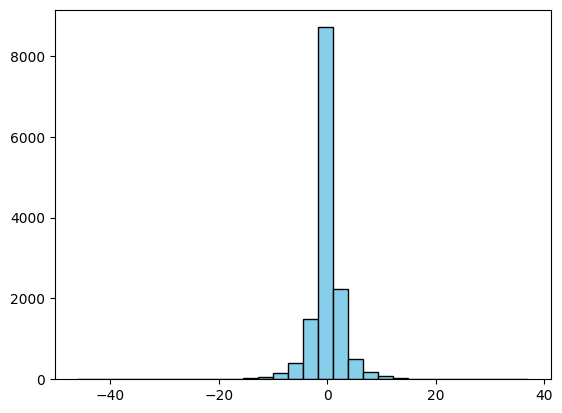

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_pred, bins=30, color='skyblue', edgecolor='black')
plt.show()

In [ ]:
import numpy as np
q1 = np.quantile(y_pred, 0.25)
q3 = np.quantile(y_pred, 0.75)

In [ ]:
bins = np.digitize(y_pred, [q1, q3])
bins[bins == 2] = 1  
bins[bins == 3] = 2

array([1, 0, 0, ..., 1, 1, 0])